In [19]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
import torch
from sae_lens import SAE
from neuronpedia.np_sae_feature import SAEFeature
import matplotlib.colors as colors
import configs
import json

In [20]:
def load_direct_regression_weights(layer, sae, pickle_dir='pickles/regression_weights_sae', brain_region='broca'):
    filepath = os.path.join(pickle_dir, f'{brain_region}_gemma2Bfeatures_L{layer}.pkl')
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    n_sae_features, _ = sae.W_dec.shape

    _W_direct = data['best_estimator'].named_steps['ridge'].coef_
    n_voxels, total_features = _W_direct.shape
    n_features = total_features // 4
    _W_direct = _W_direct.reshape(n_voxels, 4, n_features).sum(axis=1)
    W_direct = np.zeros((n_voxels, n_sae_features))
    with open(os.path.join("pickles", "dead_sae_unit_indices", f"gemma2b_L{layer}.pkl"), "rb") as f:
        alive_sae_units = pickle.load(f)['alive_units']
    W_direct[:, alive_sae_units] = _W_direct
    return W_direct

In [21]:
def load_composed_regression_weights(
        layer, sae, use_sae, pickle_dir='pickles/regression_weights', brain_region='broca'
        ):

    model_name = 'gemma2BSAE' if use_sae else 'gemma2B'
    filepath = os.path.join(pickle_dir, f'{brain_region}_{model_name}_L{layer}.pkl')
    with open(filepath, 'rb') as f:
        data = pickle.load(f)

    W_llm_to_brain = data['best_estimator'].named_steps['ridge'].coef_
    W_dec = sae.W_dec.detach().cpu().numpy()
    W_features_to_llm = np.repeat(W_dec, 4, axis=1)
    W_composed = W_features_to_llm @ W_llm_to_brain.T

    return W_composed.T

In [28]:
model_layer = 12
brain_region = 'ac'

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
release = "gemma-scope-2b-pt-res-canonical"
sae_id = f"layer_{model_layer}/width_16k/canonical"
sae = SAE.from_pretrained(release, sae_id)[0].to(device)

In [30]:
W_direct = load_direct_regression_weights(model_layer, sae, brain_region=brain_region)

In [31]:
W_composed = load_composed_regression_weights(model_layer, sae, use_sae=True, brain_region=brain_region)

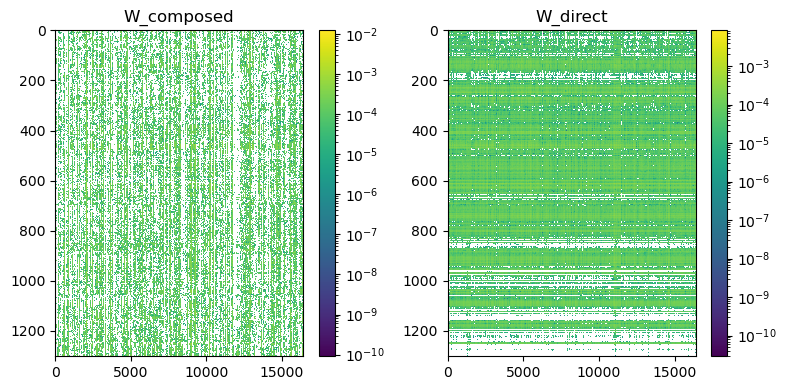

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

im = ax1.imshow(W_composed, aspect='auto')
ax1.set_title('W_composed')
im.set_norm(colors.LogNorm())
plt.colorbar(im, ax=ax1)

im = ax2.imshow(W_direct, aspect='auto')
ax2.set_title('W_direct')
im.set_norm(colors.LogNorm())
plt.colorbar(im, ax=ax2)

plt.tight_layout()
plt.show()


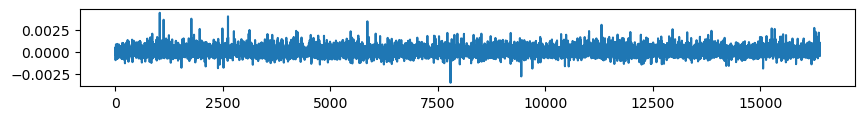

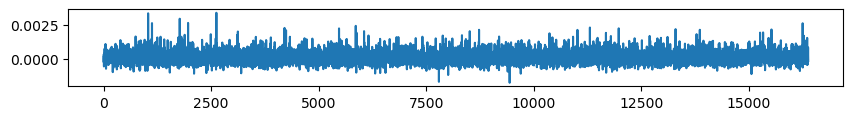

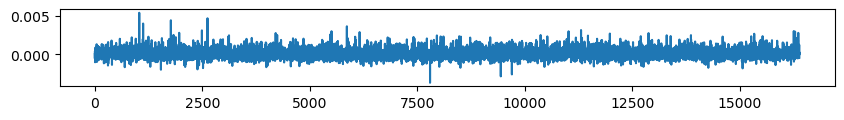

In [33]:
for voxel in range(3):
    plt.figure(figsize=(10, 1))
    plt.plot(W_direct[voxel])
    plt.show()

In [34]:
threshold = np.percentile(W_direct.flatten(), 99.999)
print(threshold)

0.005698536345595626


In [35]:
[i for i in range(W_direct.shape[1]) if np.any(W_direct[:,i]>threshold)]

[1123, 2620, 5472, 11306]

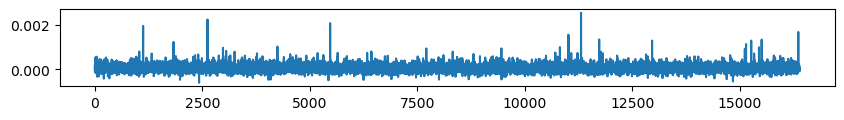

In [36]:
mean_loading = W_direct.mean(axis=0)
plt.figure(figsize=(10, 1))
plt.plot(mean_loading)
plt.show()


In [37]:
np.sum(mean_loading > 0.001)

16

In [38]:
top_indices = np.argsort(mean_loading)[-30:][::-1]  # Get indices of top 30 values in descending order
print("Top 30 feature indices by mean loading:")
print(np.sort(top_indices))


Top 30 feature indices by mean loading:
[ 1033  1123  1830  2620  2980  3054  3250  4246  5472  5647  6333  6427
  6438  7708  8322  9454 10708 10815 11013 11016 11306 11728 11767 12958
 15115 15143 15263 15444 15506 16358]


In [39]:
descriptions = []
for feature_index in top_indices:
    print(feature_index)
    sae_feature = SAEFeature.get("gemma-2-2b", "12-gemmascope-res-16k", f"{feature_index}")
    feature_info = json.loads(sae_feature.jsonData)
    this_feature_info = ''
    for idx, i in enumerate(feature_info['explanations']):
        this_feature_info += i['description']
        if idx < len(feature_info['explanations']) - 1:
            this_feature_info += ' OR '
    descriptions.append(this_feature_info)


11306
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/11306
Got a successful response.
2620
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/2620
Got a successful response.
5472
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/5472
Got a successful response.
1123
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/1123
Got a successful response.
16358
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/16358
Got a successful response.
11013
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/11013
Got a successful response.
11016
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/11016
Got a successful response.
11728
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope

In [40]:
for description in descriptions:
    print(description)
    print()

Japanese characters and terms related to web development or technology

words associated with authority, control, and criticism of governance

terms related to health and medical conditions

conversations about relationships and their complexities

questions and statements regarding intentions, plans, or purposes

articles and prepositions in the text

elements related to recognition and accolades within various fields such as music, education, and health

references to digital content and download links

requests for specific information, particularly related to procedures or guidelines

terms related to product quality and effectiveness

 instances of agreement and affirmation

sentences that express significant or definitive statements

phrases related to teamwork and sports dynamics

references to healthcare and medical terminology

terms related to research studies and methodologies, particularly in the context of trials involving psychology and treatment

 technical terms related

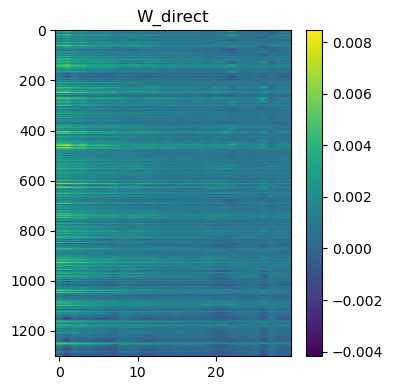

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

im = ax.imshow(W_direct[:, top_indices], aspect='auto')
ax.set_title('W_direct')
#im.set_norm(colors.LogNorm())
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [42]:
results = {
    'top_indices': top_indices,
    'descriptions': descriptions,
    'mean_loading': mean_loading,
}
with open(f'pickles/selected_features/direct_regression_L{model_layer}_{brain_region}.pkl', 'wb') as f:
    pickle.dump(results, f)
